# Классификация отзывов по тональности 

Классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

In [1]:
import json
import sqlite3

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pymystem3 import Mystem          # морфологический анализатор
from pymorphy2 import MorphAnalyzer   # морфологический анализатор
from nltk.corpus import stopwords
from nltk import FreqDist

from gensim import corpora, similarities, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as newpyLDAgensim

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from imblearn.over_sampling import ADASYN

import warnings

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
# conda install -c anaconda gensim
# conda install -c conda-forge pyldavis
# conda install -c conda-forge imbalanced-learn    (возможно, понадобиться перезапуск ядра!)

In [3]:
responses = []
with bz2.BZ2File('dataNLP/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:47, 4196.51it/s]


In [4]:
# пример отзыва
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [2]:
# задаём морфологический анализатор
m = Mystem()

# Ф-ция токенизации
# задаём простой шаблон слова (слова с "Ё" или "ё" или с дефисом - выпадают из шаблона)
regex = re.compile("[А-Яа-я]+")
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

# ф-ция разделения текста на токены без стоп-слов
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

# ф-ция лемматизации
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

# ф-ция удаления стоп-лемм
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

# ф-ция для нахождения основы слова (стэмминг)
def stemming(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()
    except:
        return " "

## 1. Анализ текстов

### 1.1 Считаем кол-во отзывов в разных городах и на разные банки

In [ ]:
# переводим загруженные данные в датафрейм
resp_matrix = []
for resp in responses:
    resp_matrix.append([resp['city'],resp['bank_name'],resp['title'],resp['text'],resp['rating_grade']])
df = pd.DataFrame(resp_matrix,columns=['city','bank','title','text','rating'])
df.head()

In [3]:
# подготовим соединение с БД
def select(sql):
    return pd.read_sql(sql,con)
con = sqlite3.connect('dataNLP/HW1.db')

In [8]:
%%time
# запихнем фрейм в БД
df.to_sql('original',con,index=False,if_exists='replace')

Wall time: 2.58 s


In [3]:
%%time
warnings.filterwarnings("ignore")
# выборка из БД
sql = '''
    SELECT *
    FROM original
    '''
df = select(sql)

Wall time: 2.5 s


In [10]:
print("всего отзывов:",df.shape[0],", из которых в", df[~df.city.isnull()].shape[0], "указаны города")

всего отзывов: 153499 , из которых в 138325 указаны города


In [4]:
# проверяем, во всех ли отзывах с городами стоит 'г.'

warnings.filterwarnings("ignore")
def f(x):
    y = ''
    if x:
        y = re.findall('г\. ',x)
    if y:
        return(y[0])
    else:
        return(np.nan)
df['temp'] = df.apply(lambda x: f(x['city']), axis=1)
df[~df.temp.isnull()].shape[0] == df[~df.city.isnull()].shape[0]

True

In [5]:
warnings.filterwarnings("ignore")
df.drop('temp', axis=1, inplace=True)

In [6]:
# Уберем все 'г. ' в начале строке-города всех отзывов
def f(x):
    patt = re.compile(r'^г. ')
    if x:
        return(patt.sub('',x))
    else:
        return(np.nan)
df['city'] = df.apply(lambda x: f(x['city']), axis=1)
df.head()

,city,bank,title,text,rating
0,Москва,Бинбанк,Жалоба,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,Новосибирск,Сбербанк России,Не могу пользоваться услугой Сбербанк он-лайн,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,Москва,Бинбанк,Двойное списание за один товар.,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,Ставрополь,Сбербанк России,Меняют проценты комиссии не предупредив и не ...,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,Челябинск,ОТП Банк,Верните денежные средства за страховку,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [7]:
warnings.filterwarnings("ignore")
# Пишем ф-цию для извлечения городов, если те присутствуют не в начале поля 'city',
# а также обрубание мусора в этом поле (область, край и т.д.), если название города в начале
def city_der(el):
    y = ''
    if el is not np.nan:
        m1 = re.match(r' ?- ?', el)
        m2 = re.match(r' ?\.+ ?', el)
        if m1 or m2:
            el = np.nan
    if el is not np.nan:
        el = el.strip(' ()')
        # case
        y1 = re.findall('г\. [А-Яа-я]+',el)
        if y1:
            if len(y1)>1:
                y1 = [y1[len(y1)-1]]
            y = re.sub('г.', '', y1[0])
            y = y.strip()
        # case  
        y9 = re.findall('г\.[А-Яа-я]+',el)
        if y9:
            if len(y9)>1:
                y9 = [y9[len(y9)-1]]
            y = re.sub('г.', '', y9[0])
            y = y.strip()
        # case
        y2 = re.findall(' город [А-Яа-я]+',el)
        if y2:
            y = re.sub(' город ', '', y2[0])
        # case
        y3 = re.findall(',город [А-Яа-я]+',el)
        if y3:
            y = re.sub(',город ', '', y3[0])
        # case
        y4 = re.findall(' гор [А-Яа-я]+',el)
        if y4:
            y = re.sub(' гор ', '', y4[0])
        # case
        y5 = re.findall(',гор [А-Яа-я]+',el)
        if y5:
            y = re.sub(',гор ', '', y5[0])
        # case
        y6 = re.findall('гор\.[А-Яа-я]+',el)
        if y6:
            y = re.sub('гор\.', '', y6[0])
        # case
        y8 = re.findall('г\.[А-Яа-я]+',el)
        if y8:
            if len(y8)>1:
                y8 = [y8[len(y8)-1]]
            y = re.sub('г.', '', y8[0])
        # case
        y7 = re.findall('г\.[а-я]\. [А-Яа-я]+',el)
        if y7:
            y = re.sub(r'г\.[а-я]\.', '', y7[0])
            y = y.strip()
        if y:
            y = y.strip()
            return(y.title())
        # если же ничего не найдено по шаблонам, обрабатываем непосредственно всю введенную юзером строку
        else:
            first = el.split()[0].title()
            citywords = ['Нижний','Верхний','Старый','Новый','Великий','Малый','Большой','Великие','Ханты','Вышний',
                         'Нижняя','Верхняя','Малая','Большая','Старая','Новая','Великие','Нижние','Верхние','Старые',
                         'Новые','Малые','Большие','Набережные','Каменск','Западная','Минеральные','Нарьян',
                         'Дальнее','Красная','Вятские','Высокая','Белая','Александровск','Усть','Кривой','Сергиев','Павловский','Переславль']
            if first in citywords:
                try:
                    city = first + ' ' + el.split()[1].title()
                    if el.split()[1] == '-':
                        try:
                            city = first + '-' + el.split()[2].title()
                        except IndexError:
                            a = 1
                    city = city.strip(' ,.-')
                except IndexError:
                    city = first
            elif first == 'Комсомольск':
                city = 'Комсомольск-на-Амуре'
            else:
                city = first
            return(city.strip(' ,'))
    else:
        return(np.nan)

In [16]:
# Удалим мусор в обработанных городах
def trash(el):
    if el is not np.nan:
        m1 = re.match(r'\d', el)
        m2 = re.match(':', el)
        m3 = re.match(';', el)
        m4 = re.match('\?', el)
        if m1 or m2 or m3 or m4:
            return(np.nan)
        else:
            if el == 'Санкт' or el == 'Санкт-':
                el = 'Санкт-Петербург'
            return(el)
    else:
        return(np.nan)

In [17]:
trash('Санкт-')

'Санкт-Петербург'

In [18]:
%%time
df['city_upd'] = df.apply(lambda x: city_der(x['city']), axis=1)
df['city_upd'] = df.apply(lambda x: trash(x['city_upd']), axis=1)

Wall time: 3.32 s


In [19]:
print("до обработки было",df.city.nunique(),"уникальных городов, а после обработки осталось", df.city_upd.nunique())

до обработки было 5823 уникальных городов, а после обработки осталось 2672


In [20]:
df.head(3)

,city,bank,title,text,rating,city_upd
0,Москва,Бинбанк,Жалоба,Добрый день! Я не являюсь клиентом банка и пор...,NaN,Москва
1,Новосибирск,Сбербанк России,Не могу пользоваться услугой Сбербанк он-лайн,Доброго дня! Являюсь держателем зарплатной кар...,NaN,Новосибирск
2,Москва,Бинбанк,Двойное списание за один товар.,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,Москва


In [21]:
# посмотрим теперь на все многословные города после обработки на предмет качества обработки
cupd = df.city_upd.unique().tolist()
for cit in cupd:
    if cit is not np.nan:
        if len(cit.split()) > 1:
            print(cit)

Нижний Новгород
Нижний Тагил
Сергиев Посад
Набережные Челны
Великий Новгород
Минеральные Воды
Павловский Посад
Старый Оскол
Великие Луки
Новый Уренгой
Верхняя Пышма
Белая Калитва
Старая Русса
Красная Сопка
Верхние Киги
Старая Купавна
Нижний Ломов
Новый Оскол
Малые Дербеты
Вышний Волочек
Большой Камень
Великий Устюг
Белая Глина
Верхний Уфалей
Большой Машляк
Верхние Серги
Верхняя Салда
Красная Поляна
Нижняя Салда
Новый Шарап
Нижняя Тура
Новая Адыгея
Большой Луг
Вятские Поляны
Верхний Баскунчак
Нижний Новнород
Великий Новгород\Москва
Нижний Ногород
Кривой Рог
Большая Таволожка
Усть Лабинск
Нижние Серги
Нижний Новгород,Бор
Старый Окол
Нижний Новогород
Нижний Новгрод
Нижний Овгород
Нижний Новгоро
Новая Москва
Белая Холуница
Павловский -Посд
Нижний Новгород-Москва
Сергиев Посад-7
Нижний Уфалей
Малые Вяземы
Набережные Челны.П.Нефтебаза
Сергиев Посад-6
Западная Двина
Нижний Новгорд
Верхняя Тура
Каменск -Шахтинский
Большие Кайбицы


Здесь остановимся, поскольку в оставшемся списке выше всё уже хорошо, за исключением опечаток и неверного ввода

Далее посмотрим на столбец 'bank'

In [202]:
df.head()

,city,bank,title,text,rating,city_upd
0,Москва,Бинбанк,Жалоба,Добрый день! Я не являюсь клиентом банка и пор...,NaN,Москва
1,Новосибирск,Сбербанк России,Не могу пользоваться услугой Сбербанк он-лайн,Доброго дня! Являюсь держателем зарплатной кар...,NaN,Новосибирск
2,Москва,Бинбанк,Двойное списание за один товар.,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,Москва
3,Ставрополь,Сбербанк России,Меняют проценты комиссии не предупредив и не ...,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,Ставрополь
4,Челябинск,ОТП Банк,Верните денежные средства за страховку,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,Челябинск


In [22]:
%%time
# запихнем обработанный фрейм в БД
df.to_sql('updated',con,index=False,if_exists='replace')

Wall time: 2.51 s


In [23]:
%%time
# выборка из БД с аггрегацией по городам и банкам, где кол-во обращений, скажем, более 500
sql = '''
    SELECT u.city_upd, u.bank, COUNT(*) AS cnt
    FROM updated AS u
    GROUP BY u.city_upd, u.bank
    HAVING COUNT(*) > 500
    ORDER BY COUNT(*) DESC
    '''
select(sql)

Wall time: 456 ms


### 1.2 Построим гистограммы длин отзывов в символах и в словах

Text(0.5, 0, 'Length of input in symbols')

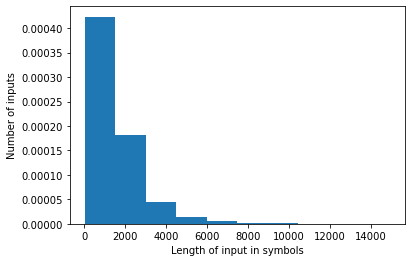

In [223]:
len_txt_sym = df.text.apply(len)
length = len_txt_sym[len_txt_sym < 15000].tolist()
# Гистограмма длины отзывов в символах
plt.hist(length,  bins=10, density=True)
plt.ylabel('Number of inputs')
plt.xlabel('Length of input in symbols')

Wall time: 15.9 s


Text(0.5, 0, 'Length of input in words')

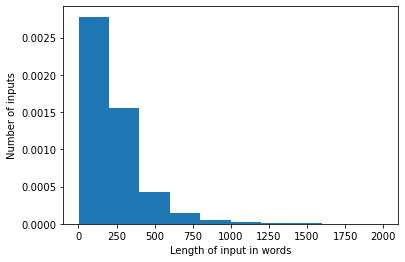

In [225]:
%%time
len_txt_wrd = df.apply(lambda x: len(x['text'].split()), axis=1)
length = len_txt_wrd[len_txt_wrd < 2000].tolist()
# Гистограмма длины отзывов в словах
plt.hist(length,  bins=10, density=True)
plt.ylabel('Number of inputs')
plt.xlabel('Length of input in words')

### 1.3 Найдём 10 самых частых: слов; слов без стоп-слов; лемм; существительных

In [24]:
%%time
# ТОКЕНИЗАЦИЯ (очистит текст от всякого мусора типо html-разметки и т.д.)

df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

Wall time: 7.62 s


In [25]:
df.text.iloc[0][:100]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каки'

In [26]:
%%time
# САМЫЕ ЧАСТЫЕ СЛОВА

n_types = []
n_tokens = []
tokens = []
# задаем объект частотного распределения слов
fd = FreqDist()
for index, row in df.iterrows():
    tokens = row['text'].split()
    # обновляем словарь, докладывая в него текущие токены
    fd.update(tokens)
    if int(index/1000) == index/1000:
        # длина словаря и есть число уникальных токенов, т.е. типов
        n_types.append(len(fd))
        # сложив все частоты, получим число токенов
        n_tokens.append(sum(list(fd.values())))
for i in fd.most_common(10):
    print(i)

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)
Wall time: 22.5 s


In [28]:
%%time
# САМЫЕ ЧАСТЫЕ СЛОВА БЕЗ СТОП_СЛОВ

# добавляем в набор русскоязычных стоп-слов дополнительные стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш', 'также', 'т', 'д']
df.text = df.text.apply(remove_stopwords)
# задаем объект словаря - частотного распределения слов
fd = FreqDist()
for row in df.text:
    tokens = row.split()
    # обновляем словарь, докладывая в него текущие токены
    fd.update(tokens)
for i in fd.most_common(10):
    print(i)

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)
Wall time: 39.6 s


In [29]:
df.text.iloc[0][:100]

'добрый день являюсь клиентом банка поручителем кредитному договору являюсь каким либо другим лицом п'

In [30]:
# ВДАЛЬНЕЙШЕМ ИЗ-ЗА МЕДЛЕННОГО КОМПЬЮТЕРА ОПЕРИРУЕМ УКОРОЧЕННЫМ ДАТАФРЕЙМОМ
data = df.iloc[:10000]

In [31]:
%%time
#САМЫЕ ЧАСТЫЕ СЛОВА ОТЛЕМАТИЗИРОВАННЫХ ОТЗЫВОВ

m = Mystem()
# Лемматизируем обновленный текст без стоп-слов
data.text = data.text.apply(lemmatize)
# Удаляем из отлемматизированного текста стоп-леммы
data.text = data.text.apply(remove_stoplemmas)

Wall time: 1h 43min 30s


In [32]:
# Посмотрим теперь на частотность слов в тексте после удаления стоп-слов, лемматизации и удаления стоп-лемм, сделанных выше
lemmata = []
for index, row in data.iterrows():
    lemmata += row['text'].split()
fd = FreqDist(lemmata)
for i in fd.most_common(10):
    print(i)

('банк', 39028)
('карта', 18950)
('мой', 10804)
('день', 10043)
('кредит', 9776)
('деньги', 9575)
('сотрудник', 9373)
('клиент', 7981)
('сумма', 6997)
('счет', 6974)


In [33]:
%%time
# поместим обработанный фрейм с отлематизированными отзывами в БД
data.to_sql('lemm_short',con,index=False,if_exists='replace')

Wall time: 168 ms


In [4]:
%%time
warnings.filterwarnings("ignore")
# выборка из БД
sql = '''
    SELECT *
    FROM lemm_short
    '''
df = select(sql)

Wall time: 227 ms


In [35]:
%%time
# САМЫЕ ЧАСТЫЕ СЛОВА-СУЩЕСТВИТЕЛЬНЫЕ

m = MorphAnalyzer()
nouns = []
for index, row in df.iterrows():
    #if int(index/1000) == index/1000:
    #    print(index)
    for token in row['text'].split():
        try:
            gr = m.parse(token)[0].tag
            if 'NOUN' in gr:
                # обновляем словарь, докладывая в него текущий токен, если он является существительным
                nouns.append(token)
        except:
            a = 1
fd_s = FreqDist(nouns)
for i in fd_s.most_common(10):
    print(i)

('банк', 39028)
('карта', 18950)
('день', 10043)
('кредит', 9776)
('деньги', 9575)
('сотрудник', 9373)
('клиент', 7981)
('сумма', 6997)
('счет', 6974)
('отделение', 6909)
Wall time: 2min


### 1.4 Построем кривую Хипса - основной критерий проверки естественной природы отзывов

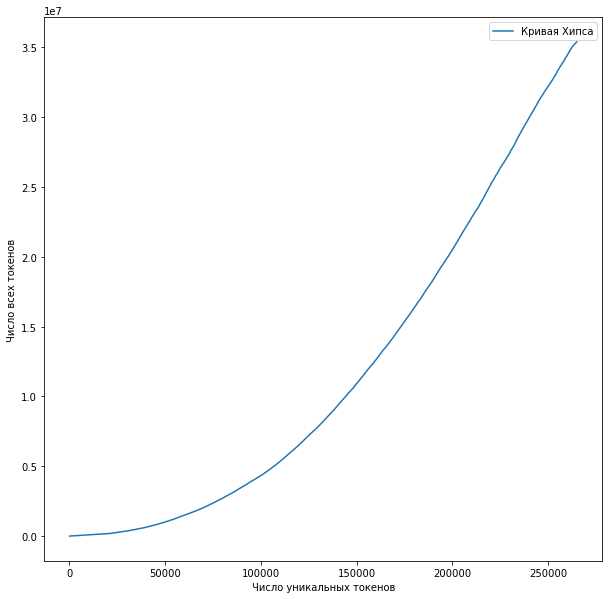

In [22]:
# Строим кривую Хипса и убеждаемся, что она монотонно возрастает
plt.figure(figsize=(10,10))
plt.plot(n_types, n_tokens, label='Кривая Хипса')

plt.xlabel('Число уникальных токенов')
plt.ylabel('Число всех токенов')
plt.legend()
plt.show()

### 1.5 Примеры простейшего частотного анализа:

In [32]:
print('частота встречаемости слова "сотрудник":',fd_s['сотрудник'], ', а слова "клиент":',fd_s['клиент'])
print('частота встречаемости слова "мошенничество":',fd_s['мошенничество'], ', а слова "доверие":',fd_s['доверие'])

частота встречаемости слова "сотрудник": 9373 , а слова "клиент": 7981
частота встречаемости слова "мошенничество": 221 , а слова "доверие": 152


### 1.6  Найдём ключевые слова и биграмы для отзывов с оценкой 5 и с оценкой 1
    * Используем меру $tf-idf$

In [130]:
%%time
# пар-ры: ngram_range=(1,1) - диапазон того, что мы считаем словом для векторного пр-ва,
# (1,1) - в м-це будут лишь слова, (1,2) - слова и все возможные пары слов, (2,3) - все возм. пары слов и тройки слов
# max_df - макс. документная частота в долях (можно выкинуть слова, встреч-ся в док-тах более чем в указ. доле случаев)
# min_df - мин. документная частота в абс. знач. (можно выкинуть слова, встреч-ся менее чем в указ. кол-ве док-тов)

rankings = pd.DataFrame(columns=['words_rating_1','bigrams_rating_1','words_rating_5','bigrams_rating_5'])

def ranking(ng,rating):
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(ng,ng), min_df=0)
    # тренируемся на списке отзывов с оценкой 'rating', сведенных в единый текст
    # результат - векторное TF-IDF представление этого сводного текста
    reviews = ''
    for review in df[df['rating'] == rating].text.tolist():
        reviews += review
    tfidf_matrix = tfidf.fit_transform([reviews])
    feature_names = tfidf.get_feature_names()
    dense = tfidf_matrix.todense()
    tfidf_ranking = []

    text = dense[0].tolist()[0]
    phrase_scores = [pair for pair in zip(range(0,len(text)),text) if pair[1]>0]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    phrases = []
    for phrase, score in [(feature_names[word_id], score) for (word_id,score) in sorted_phrase_scores]:
        tfidf_ranking.append(phrase)
    return tfidf_ranking[:10]

rankings['words_rating_1'] = ranking(1,1)
rankings['bigrams_rating_1'] = ranking(2,1)
rankings['words_rating_5'] = ranking(1,5)
rankings['bigrams_rating_5'] = ranking(2,5)
rankings

Wall time: 9.67 s


,words_rating_1,bigrams_rating_1,words_rating_5,bigrams_rating_5
0,банк,сотрудник банк,банк,интернет банк
1,карта,денежный средство,карта,кредитный карта
2,сотрудник,горячий линия,сотрудник,сотрудник банк
3,день,отделение банк,очень,другой банк
4,мой,кредитный карта,день,дебетовый карта
5,деньги,написать заявление,мой,клиент банк
6,отделение,ваш банк,клиент,отделение банк
7,кредит,колл центр,вклад,открывать вклад
8,счет,интернет банк,отделение,альфа банк
9,сказать,рабочий день,деньги,следующий день


## 2. Тематическое моделирование

### 2.1 Построим несколько тематических моделей коллекции документов с разным числом тем. 
Выделим в конце понятные (интерпретируемые) темы

In [135]:
%%time
# разбиваем всю коллекцию отзывов на слова
texts = [df.text.iloc[i].split() for i in range(len(df))]
# создаем словарь из всех текстов
dictionary = corpora.Dictionary(texts)
# создаём корпус текстов в векторном виде, на базе созданного выше словаря
corpus = [dictionary.doc2bow(text) for text in texts]
# создаём из корпуса текстов корпус в виде tf-idf 
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
# Cоздаём новый объект 'MatrixSimilarity' для подсчета в нём близости док-тов
index = similarities.MatrixSimilarity(corpus_tfidf)
# вычисляем косинусные расстояния между док-тами в корпусе (попарно)
sims = index[corpus_tfidf]

Wall time: 4min 10s


In [154]:
# здесь для отзыва №0 вывод пар (id слова, кол-во встречаемости слова в документе)
print(corpus[:1])
# посмотреть, что за слово с id=0 можно так:
print(dictionary[0])

[[(0, 3), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 4), (54, 1), (55, 1), (56, 1), (57, 2), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 3), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 3), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [156]:
# Удобочитаемая форма самого корпуса отзывов (воводим для отзыва №0)
for cp in corpus[:1]:
    for id,freq in cp:
        print(dictionary[id],':',freq)

адрес : 3
банк : 3
бесконечный : 1
бояться : 1
быть : 1
ваш : 1
весь : 1
взять : 1
владимирович : 1
возбуждение : 1
возмещение : 1
вопрос : 2
вред : 1
вынужденный : 1
вышеуказанный : 1
год : 3
город : 1
гражданин : 2
гражданский : 1
данные : 1
дело : 1
день : 1
добрый : 1
договор : 4
документ : 1
должный : 1
дом : 1
доставлять : 1
другой : 2
жалоба : 1
заверять : 1
задолженность : 1
закон : 1
зарегистрировать : 1
защита : 1
заявление : 2
знакомый : 1
иметь : 1
имущество : 1
имя : 1
какой : 2
квартира : 1
клиент : 1
коллект : 1
кредит : 1
кредитный : 2
кроме : 1
либо : 2
лицо : 1
марта : 1
меньший : 1
мера : 1
милость : 1
мой : 4
моральный : 1
москва : 1
надеяться : 1
нарушать : 2
начинать : 2
неудобство : 1
образ : 1
обращаться : 1
омбудсмен : 1
ооо : 1
орган : 1
ответственность : 1
отклонение : 1
отношение : 3
оформлять : 2
переживать : 1
переулок : 1
персональный : 1
письменно : 1
письмо : 3
повод : 1
подавать : 1
подлинность : 1
полиция : 1
понятно : 1
поручитель : 1
посылать : 1
по

In [177]:
%%time
# Хорошее руководство: https://webdevblog.ru/tematicheskoe-modelirovanie-s-pomoshhju-gensim-python/
## задаем LDA модель, число тем = 'num_topics'
# alpha, eta - пар-ры распределений, влияющие на разреженность тем, 
# passes - общее количество проходов обучения
# corpus - векторное представление коллекции док-тов
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20,
                        alpha='auto', eta='auto', iterations = 20, passes = 15)
# показываем составляющие для первых 3 тем
print(lda.show_topics(3))
# Вычисляем согласованность тем (Coherence Score)
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.478*"сбербанк" + 0.070*"онлайн" + 0.043*"россия" + 0.027*"сбер" + 0.022*"оплачивать" + 0.020*"квитанция" + 0.016*"оплата" + 0.014*"платеж" + 0.012*"реквизит" + 0.008*"оао"'), (5, '0.031*"сказать" + 0.016*"говорить" + 0.015*"приходить" + 0.014*"позвонить" + 0.013*"звонить" + 0.012*"девушка" + 0.010*"банк" + 0.010*"отвечать" + 0.009*"день" + 0.009*"спрашивать"'), (6, '0.050*"банк" + 0.023*"клиент" + 0.015*"очень" + 0.009*"время" + 0.009*"вопрос" + 0.008*"работа" + 0.007*"год" + 0.006*"отзыв" + 0.006*"проблема" + 0.006*"решать"')]

Coherence Score:  0.43910185924348333
Wall time: 5min 44s


In [158]:
# вывод всех тем по порядку, не по значимомсти
# lda.print_topics()

In [164]:
# инструмент для рисования тем в итерактивном формате

# векторное представления слов в новых темовых координатах
# один кружок - одна тема (чем он больше,тем больше распространена эта тема), 
# при нажатии на которую видим справа, какие слова в эту тему входят
# синим - скока раз это слово встречается, красным - доля вхождения слова в тему
# при нажатии на слово - увидим какая тема содержит больше всего это слово
# Хорошая тематическая модель будет иметь довольно большие непересекающиеся пузыри, разбросанные по всей диаграмме, 
# а не сгруппированные в одном квадранте
vis_data = newpyLDAgensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

#### Ищем оптимальное число тем

In [174]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                        alpha='auto', eta='auto', iterations = 20, passes = 15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [175]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=40, step=6)

Wall time: 46min 6s


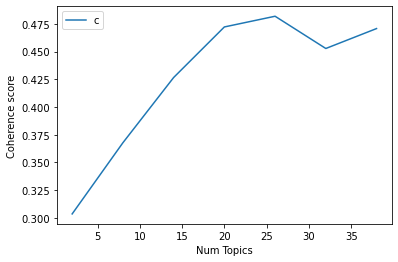

In [176]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### 2.2 Поиск доминирующей темы в каждом отзыве

In [186]:
%%time
def format_topics_sentences(ldamodel=lda, corpus=corpus, texts=df.text.tolist()):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=df.text.tolist())
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(10)

Wall time: 1min 58s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.4651,"банк, звонок, номер, ваш, телефон, мой, сотруд...",добрый день являться клиент банк поручитель кр...
1,1,12.0,0.2552,"карта, банк, дебетовый, получать, обслуживание...",добрый день являться держатель зарплатной карт...
2,2,4.0,0.5348,"банк, счет, сумма, средство, платеж, руб, задо...",здравствовать дублировать заявление можайский ...
3,3,2.0,0.2909,"вклад, банк, деньги, счет, открывать, день, за...",добрый день открывать расчетный счет сбербанк ...
4,4,10.0,0.3360,"кредит, банк, сумма, платеж, страховка, год, д...",г взять кредит ваш банк заявлять я сумма рубль...
5,5,2.0,0.2132,"вклад, банк, деньги, счет, открывать, день, за...",многий вкладчик открывать руб счастливый мысль...
6,6,12.0,0.3807,"карта, банк, дебетовый, получать, обслуживание...",здравствовать подавать заявление получение уэк...
7,7,17.0,0.3421,"вклад, банк, условие, ставка, договор, процент...",крайне удивл н новость май унификация удивл н ...
8,8,19.0,0.5297,"банк, звонок, номер, ваш, телефон, мой, сотруд...",сотрудник банк восточный систематически сообща...
9,9,10.0,0.4672,"кредит, банк, сумма, платеж, страховка, год, д...",добрый день являться заемщик банк втб год наза...


### 2.3 Распределение тем по документам

In [188]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,19.0,"банк, звонок, номер, ваш, телефон, мой, сотруд...",4.0,0.0004
1.0,12.0,"карта, банк, дебетовый, получать, обслуживание...",571.0,0.0571
2.0,4.0,"банк, счет, сумма, средство, платеж, руб, задо...",680.0,0.0680
3.0,2.0,"вклад, банк, деньги, счет, открывать, день, за...",122.0,0.0122
4.0,10.0,"кредит, банк, сумма, платеж, страховка, год, д...",680.0,0.0680
5.0,2.0,"вклад, банк, деньги, счет, открывать, день, за...",827.0,0.0827
6.0,12.0,"карта, банк, дебетовый, получать, обслуживание...",1637.0,0.1637
7.0,17.0,"вклад, банк, условие, ставка, договор, процент...",125.0,0.0125
8.0,19.0,"банк, звонок, номер, ваш, телефон, мой, сотруд...",233.0,0.0233
9.0,10.0,"кредит, банк, сумма, платеж, страховка, год, д...",382.0,0.0382


## Часть 3. Классификация текстов

Задача бинарной классификации: классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

Будем использовать accuracy и F-measure для оценки качества классификации. 

### 3.1 Составим обучающее и тестовое множество 

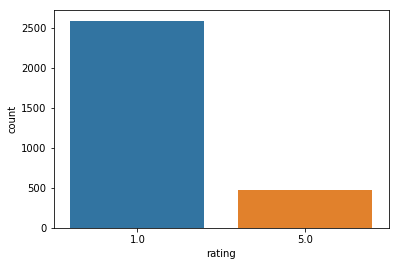

In [7]:
# оставляем только отзывы с оценками 1 или 5
data = df[(df.rating == 1) | (df.rating == 5)]
# итоговая выборка получилась несбалансированной:
warnings.filterwarnings("ignore")
sns.countplot(data.rating)

In [8]:
def get_train_test(data=data,nlow=4,ntop=6,SVD_comp=20,tfidf_flag=False,SVD_flag = False):
    # Cначала разобьём на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(data.text, data.rating, test_size = 0.2, random_state = 1)
    # Инициализируем модуль CountVectorizer
    CV = CountVectorizer(analyzer = 'char', ngram_range=(nlow,ntop))
    # Составляем словарь из X_train
    CV.fit(X_train)
    # Размер полученного словаря
    # print("Размер словаря из X_train",len(CV.vocabulary_))
    # переводит текстовые данные в числовые, по кол-ву встречающихся слов из словаря
    X_train = CV.transform(X_train)
    X_test = CV.transform(X_test)
    if tfidf_flag == True:
        # Осуществляем трансформацию TfidfTransformer - подсчет значения TF-IDF каждого слова в векторизаторе, т.е.
        # получим матрицу частот слов X_train и X_test в значения TF-IDF
        tfidf = TfidfTransformer()
        tfidf.fit(X_train)
        X_train = tfidf.transform(X_train)
        X_test = tfidf.transform(X_test)
    if SVD_flag == True:
        # снижаем размерность сингулярным разложением SVD
        SVD = TruncatedSVD(n_components=SVD_comp, random_state=0)
        SVD.fit(X_train)
        X_train = SVD.transform(X_train)
        X_test = SVD.transform(X_test)
    # Устраняем разбалансированность классов методом ADASYN
    SM = ADASYN(random_state=1)
    X_train_sm, y_train_sm = SM.fit_resample(X_train, y_train)
    # Посмотрим теперь на распределение рейтингов в тренировочной выборке
    # warnings.filterwarnings("ignore")
    # sns.countplot(y_train_sm)
    return X_train_sm,y_train_sm,X_test,y_test

### 3.2 Осуществляем классификацию

In [ ]:
# Сравним разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием 
# символьных n-грам.
# а также использования 𝑓−𝑖𝑑𝑓  преобразования и сингулярного разложения (оно же – латентый семантический анализ)

In [79]:
%%time
X_train_sm,y_train_sm,X_test,y_test = get_train_test(data=data,nlow=1,ntop=3,SVD_comp=15,tfidf_flag=True,SVD_flag=True)
model = RandomForestClassifier()
model.fit(X_train_sm,y_train_sm)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
print("Точность предсказания:",accuracy,"F1-мера:",f1)
# Confusion Matrix For predictions
cm = confusion_matrix(y_test, preds, labels=[1, 5])

Точность предсказания: 0.8562091503267973 F1-мера: 0.9143968871595332
Wall time: 7.55 s


Confusion Matrix For predictions


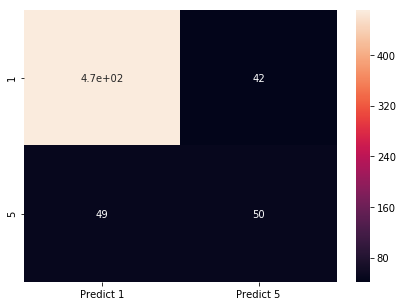

In [65]:
print("Confusion Matrix For predictions")
cm = confusion_matrix(y_test, preds, labels=[1, 5])

df_cm = pd.DataFrame(cm, index = [i for i in [1, 5]],
                  columns = [i for i in ["Predict 1","Predict 5"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

In [42]:
res = []

In [62]:
res.append([1,3,True,True,15,cm[1][0],cm[1][1],round(accuracy,3),round(f1,3)])

In [69]:
# Определяем датафрейм для записи результатов
results = pd.DataFrame(res,columns=
                       ['ngram_bttm','ngram_top','tfidf','SVD','SVD_components','False5','True5','accuracy','F1-score'])

In [78]:
results

,ngram_bttm,ngram_top,tfidf,SVD,SVD_components,False5,True5,accuracy,F1-score
0,1,1,True,True,20.0,78,21,0.812,0.892
1,1,1,False,False,NaN,78,21,0.837,0.908
2,1,3,False,False,NaN,62,37,0.895,0.941
3,2,2,False,False,NaN,76,23,0.866,0.925
4,3,3,False,False,NaN,64,35,0.884,0.934
5,1,2,False,False,NaN,72,27,0.871,0.928
6,1,2,False,False,NaN,65,34,0.884,0.935
7,1,3,True,True,20.0,49,50,0.851,0.912


In [ ]:
# Максимальный результат показывает модель с использованием от 1 до 3 n-грамм в CV-векторизации без tf-idf преобразования и
# сингулярного разложения
# Тем не менее, с той же векторизацией и с сипользованием tf-idf и SVD, определение положительных отзывов заметно улучшается